<a href="https://colab.research.google.com/github/franktcao/data_incubator_challenge/blob/master/yelp_what_is_funny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentimental Analysis with Yelp Open Dataset



##Introduction

Using [Yelp's open dataset](https://www.yelp.com/dataset) we want to get a handle on what makes a review funny. Intuitively, maybe it should be at an accessible 5th grade reading level to cast a wide net. Maybe it should be a useful or cool review. Should we expect lower stars or higher? 

We will classify the reviews as funny or unfunny using deep neural networks.

We will try to see if some sentiment analysis can be done via **convolutional layers**.




# Starting

## Setting things up

### Mounting Google Drive

Now, the file is pretty big so I've previously uploaded it to my Google drive. Let's mount it:

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Importing Useful Modules

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras


# Needed for Mac OSX
import os 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


### Loading In Data

Use the h5py package to open our previously encoded numpy array. 

In [0]:
import h5py

# datadir = 'data/partitioned/tokenized/encoded/'
datadir = 'drive/My Drive/data/yelp_encoded/'
datafile = datadir + 'encoded_review_array.h5'

h5 = h5py.File(datafile,'r')
# help(h5py.File)
# h5.keys()

data = h5['reviews']

#### Examples

h5py only loads in the data needed to complete a given operation into memory. 

In [0]:
data.shape

(6685900, 254)

And looking at the first entry

At preprocessing stage, the first four slots of the entry are dedicated to: 

0. the number of stars; 
1. the number of "useful" upvotes;
2. the number of "funny" upvotes;
3. the number of "cool" upvotes;

respectively.

The remaining 250 integers are the encoded review text. 
* If the review contains more than 250 words, it's truncated/dropped. 
* If it contains less that 250 words the unused slots are encoded with zeros. 



In [0]:
data[0]

array([    1,     6,     1,     0,   805,   548,     5,   528,    28,
          65,   103,    55,   238,  8080,   264,    11,  4895,   537,
          62,    55, 10647,   182,  9013,   737,   753,  9013,    56,
          11,  3754,  2963,   276,     2,   977,  1865,    14,    24,
        1767,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

##  Looking at the Decoded Data

### Blackbox Decoding

To decode the encoded array, we need to use the class `Vocabulary` (from C. Bernet) which encoded the vocabulary. A vocabulary was built from the 5 GB review data and then used to encode it.

In [0]:
# # View Google's directory structure
# import pprint
# print('Module paths:')
# pprint.pprint(sys.path)
# print('\nCurrent working directory:',os.getcwd())

# from os import listdir
# from os.path import isfile, join
# files = [f for f in listdir('.') if isfile(join('.',f))]
# print(files)

In [0]:
import pickle 
import sys

# Load in the Vocabulary class
sys.path.append('/content/drive/My Drive/my_python_classes/yelp')
import vocabulary


# Load in the constructed Yelp vocabulary 
with open(datadir+'index.pck', 'rb') as pckf: 
    vocab = pickle.load(pckf)

# Method to decode review
def decode_review(encoded_review):
    encoded_review = encoded_review[encoded_review != 0] # Drop all padding
    return ' '.join( vocab.decode(encoded_review) )

### Example:

In [0]:
# Again, the encoded review is after the first 4 slots (for the scores)
first_review = data[0,4:]
# Drop padding
first_review = first_review[ first_review != 0 ]
print('Encoded review:\n\t', first_review[:14], '...')
decoded = decode_review(first_review)
print('Decoded review:\n\t', ' '.join( (decoded.split())[:14] ), '...' ) 

Encoded review:
	 [ 805  548    5  528   28   65  103   55  238 8080  264   11 4895  537] ...
Decoded review:
	 total bill this horrible service ? over $ these crooks actually had nerve charge ...


The `?` is not in our vocabulary ("stop words" are left out to like "the, he, she, it, ... etc" since they don't carry much information )

# Extracting Data
Let's extract the information needed to train our neural networks.  

###Features:

In [0]:
# Attributes
stars = data[:,0]
useful = data[:,1]
funny = data[:,2]
cool = data[:,3]

# All reviews
x = data[:, 4:]

Let's look for reviews with at least 1 funny upvote

In [0]:
stars = stars[ funny > 0 ]
useful = useful[ funny > 0 ]
cool = cool[ funny > 0 ]
x = x[ funny > 0 ]

funny = funny[ funny > 0 ]


### Extracting Readability (Under Construction)

Let's use the textatistic package to extract the reading level. First we install it:

In [0]:
!pip install textatistic

Write method to make a new column for the reading level of the review

In [0]:
def get_readability_score_from_review(enc_review):
  review = decode_review(enc_review)
  return get_readability_score(review)

def get_readability_score(review):
  from textatistic import Textatistic
  
  # This helps define the end of a sentence, needed for flesch score
  review = review + '...' 
  #   print('\t',review,'\n')
  # Compute the readability scores 
  scores = Textatistic(review).scores
  
  # Flesch score gives a higher score for more readable content
  #   return scores['flesch_score']
  # Gunning-Fog score gives the equivalent grade reading level
  return scores['gunningfog_score']


print(get_readability_score_from_review(x[2]))

7.333333333333333


Now extract the readability from the reviews

In [0]:
test = np.array(list(map(get_readability_score_from_review, x)))
# df['text'].apply(get_readability_score)

ZeroDivisionError: ignored

Looks like there is an issue with the Textatistic module in extracting the Flesch score where there is a divide by zero! It looks like the sentence count is reading zero for one of these reviews... We will have to revisit this...

### Labels:
We want to know what makes a Yelp review funny, so we need to define what constitutes a funny review. So let's label what we decide is funny



In [0]:
# Since the majority of the reviews are not funny, 
# we will initialize the labels as not-funny (0)
y = np.zeros_like(funny)

# The funny reviews should have a least 1 funny upvote
y[funny>5] = 1

# y.sum()/y.shape

First, let's look at how the review frequency distribution of 'funny' upvotes of the first 1000 entries: 

(array([938.,  39.,  13.,   6.,   1.,   1.,   0.,   0.,   1.,   1.]),
 array([ 1. ,  5.1,  9.2, 13.3, 17.4, 21.5, 25.6, 29.7, 33.8, 37.9, 42. ]),
 <a list of 10 Patch objects>)

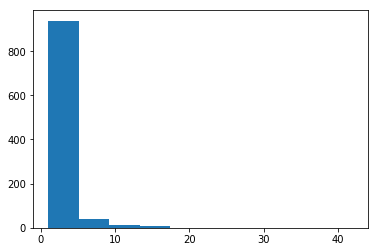

In [20]:
plt.hist(funny[:1000])

Let's see if the word count has an effect on the number of funny votes

Text(0, 0.5, 'Average number of funny votes')

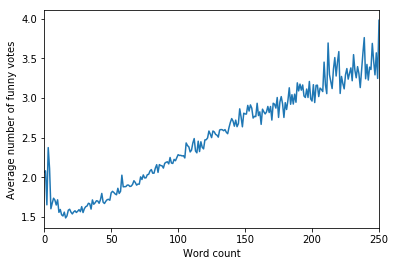

In [26]:
word_counts = np.count_nonzero(x, axis=1)
df = pd.DataFrame({'useful':useful, 'wc':word_counts, 'stars':stars, 'funny':funny, 'cool':cool})
means = df.groupby('wc').mean()

funnies = means['funny']
ax = funnies.plot()
ax.set_xlabel("Word count")
ax.set_ylabel("Average number of funny votes")

Looks like the more words, the funnier the review tends to be and this behavior is linear after 20 or so words. It might be worth investigating why this is the case for the low word count.  

Let's define a few quick methods to read out an entry that we're interested in:

In [0]:
def print_entry(ientry):
    print()
    print('\tReview number:','{:,}'.format(ientry))
    print('\tStars:', stars[ientry])
    print('\tFunny votes:', funny[ientry])
    print('\tUseful votes:', useful[ientry])
    print('\tCool votes:', cool[ientry])
    print('\t\t',decode_review(get_entry_review(ientry)))
    print()
          
def get_entry_review(ientry):
    return x[ientry]


# Applying Machine Learning


## Convolutional Network

In natural language processing, we deal with a sentences, where it's not just a collection of independent words concatenated together. Rather, collection of words/subsets of the sentence bring out the semantics. 

The best way to visualize what a convultional network does is to consider a kernel size of 3. This is a window of 3 words long, where the idea is to extract the context from the sentence. Here is an illustrative example of what the convolutional layer sees when going through the review. The kernel or window moves by one word, and the kernel can be see as the boldface below: 

* **this movie is** really not good
* this **movie is really** not good
* this movie **is really not** good
* this movie is **really not good** 

Possibly the most "meaningful" sequence of words for a review would be **really not good** since it carries a lot of information. It will be easy for the network to understand the meaning of **not good** due to the convolution nature.

* a kernel size of 3,
* 64 filters. This means that 64 features (values) will be extracted from each position of the kernel,
* a ReLU activation. 


In [0]:
k = 10**3
M = k * k

In [31]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x[:1020*k], y[:1020*k], 
                                                    test_size=20*k)
model = keras.Sequential()
model.add(keras.layers.Embedding(len(vocab.words), 64, input_length=250))
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.4))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_conv = model.fit(x_train, y_train,
                         epochs=4,
                         batch_size=1000,
                         validation_data=(x_test, y_test),
                         verbose=0)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 64)           1280128   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 248, 64)           12352     
_________________________________________________________________
flatten_2 (Flatten)          (None, 15872)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15872)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                793650    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 2,086,181
Trainable params: 2,086,181
Non-trainable params: 0
_________________________________________________________________


Let's check the quality of the fit to see how well it classifies un/funny reviews. Particularly, let's check the ROC curve:

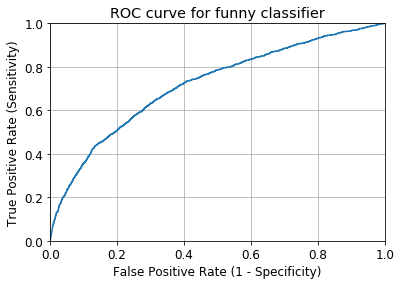

In [35]:
from sklearn import metrics
y_pred_prob = model.predict(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for funny classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

It doesn't look that great on the testing data. The curve is not too different from a straight line. Let's check how the training and testing accuracies look:

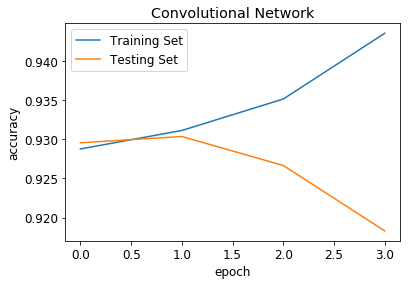

<Figure size 432x288 with 0 Axes>

In [36]:
import matplotlib.pyplot as plt
def plot_accuracy(history, title, miny=None):
    '''Plot the training and validation accuracy'''
    acc = history.history['acc']
    test_acc = history.history['val_acc']
    epochs = range(len(acc))
    plt.plot(epochs, acc)
    plt.plot(epochs, test_acc)
    if miny:
        plt.ylim(miny, 1.0)
    plt.title(title) 
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend( ['Training Set', 'Testing Set'] )
    plt.figure()
    
plot_accuracy(history_conv, 'Convolutional Network')

**Yikes**! That's quite a bit of overfitting. Even though it seems natural to apply convolutional networks, our model may be over complicated for this analysis (as shown in the opposite trends of the testing and training set for the accuracy plot). A dense neural network or a random forest regressor may have been better for this but it made sense to extract sentimental analysis by including correlations between the words.